# Introduction #
This is the development portal for the process of symmetry function pre-compiling. We will generate the necessary arrays to loop forward in the following.
<br/>
In brief summary, we will convert the Gparam_dict into many arrays for running. 

In [1]:
import SymmFuncIndPython
import numpy as np
from Utils.TestGen import get_test_glycine_mol
from Utils.TestGen import get_test_Gparam_dict
import YeltsinNet.src_nogrd as src_nogrd
import pandas as pd
from ase import Atoms
import pprint

## Benchmark Generating ##
For this section, I will write a function that generates the desired array by the original symmetry function.


<br/>
For Molecular Dyanamics, assume that the at_idx_map does not change, the benchmark would work very well for all following geometries. (Since it only needs to "compile" it during the first time. The following iterations just need to change the neighbour list. (It is even possible to get atom, atom_pair -> Gparams, symm_count.
<br/>
For training with different geometry, it is required to redo the computation (using the benchmark method). Therefore it is recommended to use the independent generating method.


### Case: All Element Interaction ##
In case of all element interaction (no explicitly forbidden interactions in ang_list), it is observed that counts are still different by different cases. However, it is hypothesized that if the full `count_Gparam` is given, it should be applicable for all cases. 

In [2]:
def symm_func_process_benchmark(distance, at_idx_map, Gparam_dict, n_atoms):
    """Convert the Gparam_dict from the old symmetry functions, and 
    use for benchmark to compare with later versions. 
    
            Outputs:
                count_Gparam: 
                    count_Gparam[count] = Gparam_list for that count
                    
                atom_to_count:
                    atom_to_count[at_idx] = [count it should appear as a neighbour]
                
                pair_to_count:
                    pair_to_count[pair] = [count it should appear as a neighbour pair]
    
    Assumption:
    
    It is observed that each count will be looped many times. 
    But it should be safe to assume that Gparam for each count
    is indepent of other varaibles. 
    
    
    Comment:
    It is found that that for the benchmark, some of the values might be 0 
    if there is no such element or element pair. 

    """
    #pdb.set_trace()
    count_Gparam = {}
    
    def atom_count_generator(n_atoms):
        """It is necessary to initialize the array first
        then put in values in the list. 
        
        
        """
        atom_count = {}
        for at_idx in np.arange(n_atoms):
            atom_count[at_idx] = []
        
        return atom_count
    
    def pair_count_generator(n_atoms):
        pair_count = {}
        for at_idx_1 in np.arange(n_atoms):
            for at_idx_2 in np.arange(at_idx_1+1, n_atoms):
                pair_count[(at_idx_1, at_idx_2)] = []
        
        return pair_count
    atom_count = atom_count_generator(n_atoms)
    pair_count = pair_count_generator(n_atoms)
    print(pair_count)
        
    #pair_count = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

    # This for loop goes through elements
    # Are together
    for at_type in at_idx_map.keys():
        Gparam_rad = Gparam_dict[at_type]['rad']
        Gparam_ang = Gparam_dict[at_type]['ang']
        print("at1_type")
        print(at_type)

        #Gfunc_data[at_type] = pd.Series([])
        count_Gparam[at_type] = {}
        

        rad_count = sum([Gparam_rad[t].shape[0] for t in Gparam_rad.keys()])
        ang_count = sum([Gparam_ang[t].shape[0] for t in Gparam_ang.keys()])


        ## This for loop goes through all the atoms (belong to the same element)
        for at1 in at_idx_map[at_type]:
            count_Gparam[at_type][at1] = np.zeros( ((rad_count+ang_count), 3))
            G_temp_count = 0

            # radial components
            for at2_type in Gparam_rad.keys():
                comp_count =  Gparam_rad[at2_type].shape[0]

                for count, values in enumerate(Gparam_rad[at2_type]):
                    #pdb.set_trace()
                    for at2 in at_idx_map[at2_type][at_idx_map[at2_type]!=at1]:

                        dist = tuple(sorted([at1, at2]))
                        R12_array = distances[dist].values[:1]
                        # values[0] = Rs, values[1] = eta (integer, not array)
                        # Then Calculate the radial symmetric function -> value of G.
                        
                        
                        
                        count_Gparam[at_type][at1][G_temp_count + count][0] = values[0]
                        count_Gparam[at_type][at1][G_temp_count + count][1] = values[1]
                        atom_count[at2].append(G_temp_count + count)

                        
                        

                #Gfunc_data[at_type][at1][:,G_temp_count:G_temp_count+comp_count] = G_temp_component
                G_temp_count += comp_count
            
            
            print("Start Angular Loop")
            # ======================
            # angular components
            for atAatB_type in Gparam_ang.keys():
                comp_count = Gparam_ang[atAatB_type].shape[0]
                #G_temp_component = np.zeros((Nsamples, comp_count))

                # This for loop goes through all 'HH', 'HO' combo?
                for count, values in enumerate(Gparam_ang[atAatB_type]):
                    atA_list = at_idx_map[atAatB_type[0]][at_idx_map[atAatB_type[0]]!=at1]
                    for atA in atA_list:
                        dist_1A = tuple(sorted([at1, atA]))
                        #R1A_array = distances[dist_1A].values[:Nsamples]

                        if atAatB_type[0] == atAatB_type[1]:
                            atB_list = at_idx_map[atAatB_type[1]][(at_idx_map[atAatB_type[1]]!=at1) & (at_idx_map[atAatB_type[1]]>atA)]
                        else:
                            atB_list = at_idx_map[atAatB_type[1]][(at_idx_map[atAatB_type[1]]!=at1)]

                        for atB in atB_list:
                            dist_1B = tuple(sorted([at1, atB]))
                            dist_AB = tuple(sorted([atA, atB]))
                            #R1B_array = distances[dist_1B].values[:Nsamples]
                            #RAB_array = distances[dist_AB].values[:Nsamples]

                            count_Gparam[at_type][at1][G_temp_count + count][0] = values[0]
                            count_Gparam[at_type][at1][G_temp_count + count][1] = values[1]
                            count_Gparam[at_type][at1][G_temp_count + count][2] = values[2]
                            
                            pair_count[dist_AB].append(G_temp_count+count)


                            #count_Gparam[at_type][at1][G_temp_count+count] = {values[0], values[1], values[2]}
                            #ang_temp = angular_filter(R1A_array, R1B_array, RAB_array, values[0], values[1], values[2])
                
                G_temp_count += comp_count

    return count_Gparam, atom_count, pair_count

    

In [3]:


test_glycine = get_test_glycine_mol()

at_idx_map = src_nogrd.at_idx_map_generator(test_glycine)
Gparam_dict = get_test_Gparam_dict(at_idx_map) 
md_samplesArr = pd.Series([test_glycine])
nAtoms, xyzArr = src_nogrd.xyzArr_generator(md_samplesArr)
distances = src_nogrd.distances_from_xyz(xyzArr, nAtoms)

# Assume that Gparam_dict and at_idx_map is the save for all the
# configurations
# It is possible to generate at_idx_map for each individual configurations
# That will consume much more time
count_Gparam, atom_count, pair_count = symm_func_process_benchmark(distances, at_idx_map, Gparam_dict, 10)

['C', 'O', 'C', 'H', 'H', 'N', 'H', 'H', 'O', 'H']
{(0, 1): [], (0, 2): [], (0, 3): [], (0, 4): [], (0, 5): [], (0, 6): [], (0, 7): [], (0, 8): [], (0, 9): [], (1, 2): [], (1, 3): [], (1, 4): [], (1, 5): [], (1, 6): [], (1, 7): [], (1, 8): [], (1, 9): [], (2, 3): [], (2, 4): [], (2, 5): [], (2, 6): [], (2, 7): [], (2, 8): [], (2, 9): [], (3, 4): [], (3, 5): [], (3, 6): [], (3, 7): [], (3, 8): [], (3, 9): [], (4, 5): [], (4, 6): [], (4, 7): [], (4, 8): [], (4, 9): [], (5, 6): [], (5, 7): [], (5, 8): [], (5, 9): [], (6, 7): [], (6, 8): [], (6, 9): [], (7, 8): [], (7, 9): [], (8, 9): []}
at1_type
H
Start Angular Loop
Start Angular Loop
Start Angular Loop
Start Angular Loop
Start Angular Loop
at1_type
O
Start Angular Loop
Start Angular Loop
at1_type
C
Start Angular Loop
Start Angular Loop
at1_type
N
Start Angular Loop


In [4]:
pp = pprint.PrettyPrinter(indent=4)
np.array_equal(count_Gparam['C'][0], count_Gparam['N'][5])
#pp.pprint(count_Gparam['C'][0])

pp.pprint(set(atom_count[3]))

{   24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47}


In [5]:
pp.pprint(count_Gparam['N'][5])

array([[ 8.00000000e-01,  1.95312500e+01,  0.00000000e+00],
       [ 1.11304348e+00,  1.00898743e+01,  0.00000000e+00],
       [ 1.42608696e+00,  6.14636005e+00,  0.00000000e+00],
       [ 1.73913043e+00,  4.13281250e+00,  0.00000000e+00],
       [ 2.05217391e+00,  2.96812159e+00,  0.00000000e+00],
       [ 2.36521739e+00,  2.23443582e+00,  0.00000000e+00],
       [ 2.67826087e+00,  1.74262629e+00,  0.00000000e+00],
       [ 2.99130435e+00,  1.39697556e+00,  0.00000000e+00],
       [ 3.30434783e+00,  1.14482341e+00,  0.00000000e+00],
       [ 3.61739130e+00,  9.55254369e-01,  0.00000000e+00],
       [ 3.93043478e+00,  8.09149601e-01,  0.00000000e+00],
       [ 4.24347826e+00,  6.94170334e-01,  0.00000000e+00],
       [ 4.55652174e+00,  6.02064638e-01,  0.00000000e+00],
       [ 4.86956522e+00,  5.27144452e-01,  0.00000000e+00],
       [ 5.18260870e+00,  4.65385850e-01,  0.00000000e+00],
       [ 5.49565217e+00,  4.13877233e-01,  0.00000000e+00],
       [ 5.80869565e+00,  3.70469764e-01

## Independent Array Generating ##
In this section, we will generate thoes arrays by self-designed algorithm. <br/>
Now began to test the entirely new symmetry function generation by pre-compiling. 

In [6]:
at_idx_map = src_nogrd.at_idx_map_generator(test_glycine)
Gparam_dict = get_test_Gparam_dict(at_idx_map) 
md_samplesArr = pd.Series([test_glycine])
nAtoms, xyzArr = src_nogrd.xyzArr_generator(md_samplesArr)


In [7]:
from SymmFuncIndPython import distance_xyz_brutal_mol
from CompileArr import compile_Gparam_const
from src_nogrd import at_ele_arr_generator
from SymmFuncIndPython import symm_func_mol_arr
distance_arr = distance_xyz_brutal_mol(xyzArr, nAtoms)
at_ele_arr = at_ele_arr_generator(test_glycine)
ang_list = angList = np.array(['HH', 'HC', 'HN', 'HO','CC','CO','CN','OO','ON','NN'])

In [8]:
count_dict, count_Gparam, n_symm_func = compile_Gparam_const(at_idx_map, Gparam_dict) 

24
48
72
96
114
132
150
168
186
204
222
240
258
276


In [9]:
distance_arr

array([1.07      , 1.06999704, 1.74729546, 1.74729709, 1.74730291,
       2.02322487, 2.64648128, 1.03200542, 1.70586541, 1.74730291,
       2.04888785, 2.04888924, 2.69277575, 3.00316355, 3.45390171,
       1.86681279, 2.70678012, 1.06999835, 1.06999924, 1.07      ,
       1.70671166, 1.70672226, 1.86681795, 2.11917536, 1.7472995 ,
       1.74730371, 2.02322262, 2.0232333 , 2.58229209, 2.87279976,
       1.74730426, 2.64647326, 2.0232358 , 2.58229247, 2.87279956,
       1.01999319, 1.02000042, 2.02931719, 1.7684163 , 1.66564747,
       1.9857066 , 1.54933013, 3.0470367 , 2.73747455, 0.93700273])

In [10]:
count_dict

{'C': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 'H': array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47]),
 'N': array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71]),
 'O': array([72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
        89, 90, 91, 92, 93, 94, 95]),
 'HH': array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113]),
 'HC': array([114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131]),
 'HN': array([132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149]),
 'HO': array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167]),
 'CC': array([168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,

In [11]:
count_Gparam

array([[ 8.00000000e-01,  1.95312500e+01,  0.00000000e+00],
       [ 1.11304348e+00,  1.00898743e+01,  0.00000000e+00],
       [ 1.42608696e+00,  6.14636005e+00,  0.00000000e+00],
       [ 1.73913043e+00,  4.13281250e+00,  0.00000000e+00],
       [ 2.05217391e+00,  2.96812159e+00,  0.00000000e+00],
       [ 2.36521739e+00,  2.23443582e+00,  0.00000000e+00],
       [ 2.67826087e+00,  1.74262629e+00,  0.00000000e+00],
       [ 2.99130435e+00,  1.39697556e+00,  0.00000000e+00],
       [ 3.30434783e+00,  1.14482341e+00,  0.00000000e+00],
       [ 3.61739130e+00,  9.55254369e-01,  0.00000000e+00],
       [ 3.93043478e+00,  8.09149601e-01,  0.00000000e+00],
       [ 4.24347826e+00,  6.94170334e-01,  0.00000000e+00],
       [ 4.55652174e+00,  6.02064638e-01,  0.00000000e+00],
       [ 4.86956522e+00,  5.27144452e-01,  0.00000000e+00],
       [ 5.18260870e+00,  4.65385850e-01,  0.00000000e+00],
       [ 5.49565217e+00,  4.13877233e-01,  0.00000000e+00],
       [ 5.80869565e+00,  3.70469764e-01

In [12]:
n_symm_func

276

In [13]:
at_ele_arr

array(['C', 'O', 'C', 'H', 'H', 'N', 'H', 'H', 'O', 'H'], dtype='<U1')

In [14]:
at_ele_arr[0]

'C'

In [15]:
from SymmFuncIndPython import get_neighbour

neighbourlist_arr, neighbourpair_arr = get_neighbour(distance_arr, nAtoms)

In [16]:
neighbourlist_arr

array([[1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [17]:
neighbourpair_arr[2]

array([[0, 1],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [0, 7],
       [0, 8],
       [0, 9],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [1, 7],
       [1, 8],
       [1, 9],
       [3, 4],
       [3, 5],
       [3, 6],
       [3, 7],
       [3, 8],
       [3, 9],
       [4, 5],
       [4, 6],
       [4, 7],
       [4, 8],
       [4, 9],
       [5, 6],
       [5, 7],
       [5, 8],
       [5, 9],
       [6, 7],
       [6, 8],
       [6, 9],
       [7, 8],
       [7, 9],
       [8, 9]])

In [43]:
#Gfunc_data = symm_func_mol_arr(distance_arr, at_ele_arr,
#
#)
Gfunc_data = symm_func_mol_arr(distance_arr, at_ele_arr,
                              neighbourlist_arr, neighbourpair_arr, 
                              count_Gparam, count_dict,
                               ang_list,
                              nAtoms, n_symm_func)

0
1
2
3
4
5
6
7
8
0
1
9
0
2
10
0
3
11
0
4
12
0
5
13
0
6
14
0
7
15
0
8
16
1
2
17
1
3
18
1
4
19
1
5
20
1
6
21
1
7
22
1
8
23
2
3
24
2
4
25
2
5
26
2
6
27
2
7
28
2
8
29
3
4
30
3
5
31
3
6
32
3
7
33
3
8
34
4
5
35
4
6
36
4
7
37
4
8
38
5
6
39
5
7
40
5
8
41
6
7
42
6
8
43
7
8
44
0
9
10
11
12
13
14
15
16
0
9
1
0
10
2
0
11
3
0
12
4
0
13
5
0
14
6
0
15
7
0
16
8
9
10
17
9
11
18
9
12
19
9
13
20
9
14
21
9
15
22
9
16
23
10
11
24
10
12
25
10
13
26
10
14
27
10
15
28
10
16
29
11
12
30
11
13
31
11
14
32
11
15
33
11
16
34
12
13
35
12
14
36
12
15
37
12
16
38
13
14
39
13
15
40
13
16
41
14
15
42
14
16
43
15
16
44
1
9
17
18
19
20
21
22
23
1
9
0
1
17
2
1
18
3
1
19
4
1
20
5
1
21
6
1
22
7
1
23
8
9
17
10
9
18
11
9
19
12
9
20
13
9
21
14
9
22
15
9
23
16
17
18
24
17
19
25
17
20
26
17
21
27
17
22
28
17
23
29
18
19
30
18
20
31
18
21
32
18
22
33
18
23
34
19
20
35
19
21
36
19
22
37
19
23
38
20
21
39
20
22
40
20
23
41
21
22
42
21
23
43
22
23
44
2
10
17
24
25
26
27
28
29
2
10
0
2
17
1
2
24
3
2
25
4
2
26
5
2
27
6
2
28
7
2
29
8

In [19]:
from SymmFuncIndPython import distance_xyz_index

In [20]:
index = distance_xyz_index(0,1,10)

In [21]:
print(index)

0


In [23]:
Gfunc_data.shape

(10, 1, 276)

### Check whether the new method is correct by comparing with Gfunc_data


276
(276,)
(276,)


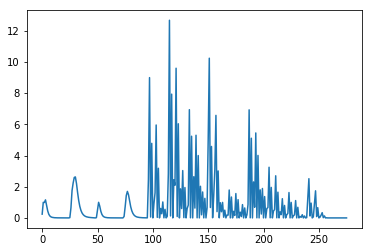

In [37]:
from SymmFuncIndPython import symm_func_show_ind
import matplotlib.pyplot as plt
n_symm = Gfunc_data[0].shape[1]
print(n_symm)

x_index = np.arange(n_symm)

print(x_index.shape)
print(Gfunc_data[0][0].shape)
#plt.plot(n_symm, Gfunc_data[0][0])
#plt.show()

plt.plot(x_index, Gfunc_data[4][0])

In [38]:
from ModelIO import read_data_from_pickle

In [45]:
Gfunc_data_bench = read_data_from_pickle('/home/junmian/Applications/YeltsinNet/model/dftb/', "Gfunc_data_test.pkl")

In [46]:
np.array_equal(Gfunc_data_bench['H'][4], Gfunc_data[4]) 

False

In [49]:
np.where(Gfunc_data_bench['H'][4][0,] == Gfunc_data[4])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  1

In [50]:
Gfunc_data_bench['H'][4][0,].shape

(276,)

In [52]:
Gfunc_data[4][0,].shape

(276,)

In [53]:
np.array_equal(Gfunc_data[4][0,],Gfunc_data_bench['H'][4][0,])

False

In [55]:
np.where(Gfunc_data[4][0,] != Gfunc_data_bench['H'][4][0,])

(array([116, 124, 125, 126, 127, 131, 150, 151, 152, 156, 157, 159, 164]),)

In [56]:
from SymmFuncIndPython import symm_func_mol
Gfunc_re = symm_func_mol(test_glycine, at_idx_map, Gparam_dict)

In [65]:
Gfunc_data[4][0,][116]

0.12611271808109323

In [68]:
for wrong_idx in np.where(Gfunc_data[3][0,] != Gfunc_re['H'][3][0,])[0]:
    print(wrong_idx)
    print(Gfunc_data[4][0,][wrong_idx])
    print(Gfunc_re['H'][4][0,][wrong_idx])

117
7.936324886465568
7.936324886465568
119
2.4458004598264695
2.4458004598264695
122
0.08846505516526038
0.08846505516526038
126
0.6010055807085805
0.6010055807085806
127
3.0356435848125205
3.035643584812521
128
0.018858136653508058
0.018858136653508058
154
0.009730087359911564
0.009730087359911564
156
3.0765478351787254
3.076547835178726
162
0.39561317134777174
0.39561317134777174
163
0.994787826983704
0.994787826983704


### Conclusion (Test): OK for running !
Based on the above comparison, we are able to conclude that the new symmetry function (pre-compiled) is able to generate the same results as the old ones since all the tiny differences are only tiny numerical differences of no significance. 